In [11]:
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from keras import models
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [21]:
TRAIN_DATA_DIR = 'data/final_ver21/train/'
#TEST_DATA_DIR = 'data/final_ver3/test/'

TRAIN_NEGATIVE_DATA_DIR = 'data/final_ver21/train_negative/'
#TEST_NEGATIVE_DATA_DIR = 'data/final_ver3/test_negative/'

train_fire_size = []
#test_fire_size = []

train_X = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []
train_file = []

#test_X = []
#test_spectrograms = []
#test_mel_spectrograms = []
#test_mfccs = []
#test_y = []
#test_file = []

#pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
#pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))

TRAIN_DATA_DIR = 'data/ver1/train3/final_positive/'
TEST_DATA_DIR = 'data/ver1/test3/final_positive/'

TRAIN_NEGATIVE_DATA_DIR = 'data/ver1/train3/final_negative/'
TEST_NEGATIVE_DATA_DIR = 'data/ver1/test3/final_negative/'

In [22]:
def padding(a, i) :
    if (a.shape[1] >= i) :
        return a[:, 0:i]
    else :
        difference = i-a.shape[1]
        zeros = np.random.randint(difference+1)
        
        #print(zeros, difference-zeros)
        
        first = np.zeros((a.shape[0], zeros))
        second = np.zeros((a.shape[0], difference - zeros))
        
        new = np.hstack((first, a))
        new = np.hstack((new, second))
        
        return new

In [23]:
for fname in os.listdir(TRAIN_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        train_file.append(TRAIN_DATA_DIR + fname)
        wav, sr = librosa.load(TRAIN_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        mfcc_normalize = librosa.util.normalize(mfcc,norm=None)
        padded_mfcc = padding(mfcc_normalize, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        train_mfccs.append(padded_mfcc)
        train_mel_spectrograms.append(padded_mel_spectrogram)
        train_y.append(1)
    except Exception as e:
        print(fname, e)
        raise

In [24]:
#np.max(train_fire_size)

for fname in os.listdir(TEST_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        test_file.append(TEST_DATA_DIR + fname)
        wav, sr = librosa.load(TEST_DATA_DIR + fname, sr=16000)
        
        #if(len(wav) > 20000) :
         #   wav = librosa.effects.time_stretch(wav, 1.5)
            
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        test_fire_size.append(len(mfcc[0]))
        padded_mfcc = padding(mfcc, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        
        test_mfccs.append(padded_mfcc)
        test_mel_spectrograms.append(padded_mel_spectrogram)
        test_y.append(1)
    except Exception as e:
        print(fname, e)
        raise

In [25]:
for fname in os.listdir(TRAIN_NEGATIVE_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        train_file.append(TRAIN_NEGATIVE_DATA_DIR + fname)
        wav, sr = librosa.load(TRAIN_NEGATIVE_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        mfcc_normalize = librosa.util.normalize(mfcc,norm=None)
        padded_mfcc = padding(mfcc_normalize, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        train_mfccs.append(padded_mfcc)
        train_mel_spectrograms.append(padded_mel_spectrogram)
        train_y.append(0)
    except Exception as e:
        print(fname, e)
        raise

for fname in os.listdir(TEST_NEGATIVE_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        test_file.append(TEST_NEGATIVE_DATA_DIR + fname)
        wav, sr = librosa.load(TEST_NEGATIVE_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        
        padded_mfcc = padding(mfcc, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        test_mfccs.append(padded_mfcc)
        test_mel_spectrograms.append(padded_mel_spectrogram)
        test_y.append(0)
    except Exception as e:
        print(fname, e)
        raise

print(len(train_fire_size))
print(np.max(train_fire_size))
print(np.mean(train_fire_size))

print(len(test_fire_size))
print(np.max(test_fire_size))
print(np.mean(test_fire_size))

In [26]:
train_mfccs = np.array(train_mfccs)
train_mel_spectrograms = np.array(train_mel_spectrograms)
train_y = np.array(train_y)
train_y = to_categorical(np.array(train_y))

#test_mfccs = np.array(test_mfccs)
#test_mel_spectrograms = np.array(test_mel_spectrograms)
#test_y = np.array(test_y)
#test_y = to_categorical(np.array(test_y))

print('train_mfccs', train_mfccs.shape)
print('train_mel_spectrograms', train_mel_spectrograms.shape)
print('train_y', train_y.shape)

#print('test_mfccs', test_mfccs.shape)
#print('test_mel_spectrograms', test_mel_spectrograms.shape)
#print('test_y', test_y.shape)

train_mfccs (72482, 20, 63)
train_mel_spectrograms (72482, 128, 63)
train_y (72482, 2)


In [27]:
train_X_ex = np.expand_dims(train_mfccs, -1)
#test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
#print('test X shape:', test_X_ex.shape)

train X shape: (72482, 20, 63, 1)


In [28]:
train_X_ex_mel = np.expand_dims(train_mel_spectrograms, -1)
#test_X_ex_mel = np.expand_dims(test_mel_spectrograms, -1)
print('train X shape:', train_X_ex_mel.shape)
#print('test X shape:', test_X_ex_mel.shape)

train X shape: (72482, 128, 63, 1)


In [29]:
np.save(os.path.join("data/dataset", "train_X.npy"), train_X_ex)
np.save(os.path.join("data/dataset", "train_X_mel.npy"), train_X_ex_mel)
np.save(os.path.join("data/dataset", "train_file.npy"), train_file)
np.save(os.path.join("data/dataset", "train_y.npy"), np.array(train_y))

#np.save(os.path.join("data/dataset", "test_X.npy"), test_X_ex)
#np.save(os.path.join("data/dataset", "test_X_mel.npy"), test_X_ex_mel)
#np.save(os.path.join("data/dataset", "test_file.npy"), test_file)
#np.save(os.path.join("data/dataset", "test_y.npy"), np.array(test_y))

In [10]:
all_X_ex = np.load(os.path.join('data/dataset_ver1', 'train_X.npy'))
all_X_ex_mel = np.load(os.path.join('data/dataset_ver1', 'train_X_mel.npy'))
all_file = np.load(os.path.join('data/dataset_ver1', 'train_file.npy'))
all_y = np.load(os.path.join('data/dataset_ver1', 'train_y.npy'))

#test_X_ex = np.load(os.path.join('data/dataset', 'test_X.npy'))
#test_X_ex_mel = np.load(os.path.join('data/dataset', 'test_X_mel.npy'))
#test_file = np.load(os.path.join('data/dataset', 'test_file.npy'))
#test_y = np.load(os.path.join('data/dataset', 'test_y.npy'))

train_X_ex, train_X_ex_mel, train_y, train_file = shuffle(train_X_ex, train_X_ex_mel, train_y, train_file, random_state=1523)
#test_X_ex, test_X_ex_mel, test_y, test_file = shuffle(test_X_ex, test_X_ex_mel, test_y, test_file, random_state=1523)

In [335]:
train_X_ex, validation_X_ex, train_X_ex_mel, validation_X_ex_mel, train_y, validation_y, train_file, validation_file =\
train_test_split(all_X_ex, all_X_ex_mel, all_y, all_file, test_size = 0.18, random_state=42)

In [336]:
len(train_X_ex)

2952

In [337]:
np.max(train_X_ex)

240.24344

In [338]:
np.mean(train_X_ex)

-14.966975

In [339]:
train_y

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [340]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(64, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)


m=Flatten()(m)
m=Dense(32, activation='relu')(m)
op=Dense(2, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 20, 63, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 17, 60, 64)        1088      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 15, 64)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 3840)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                122912    
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 66        
Total params: 124,066
Trainable params: 124,066
Non-trainable params: 0
_______________________________________________

In [341]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)

checkpoint = ModelCheckpoint('model/train_X_ex_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [342]:
history = model.fit(train_X_ex,
                    train_y,
                    epochs=400,
                    batch_size=32,
                    verbose=1,
                    validation_data=(validation_X_ex, validation_y),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/400
90/93 [============================>.] - ETA: 0s - loss: 2.1487 - accuracy: 0.5330
Epoch 00001: val_loss improved from inf to 1.70439, saving model to model\train_X_ex_best.h5
93/93 [==============================] - 1s 11ms/step - loss: 2.1290 - accuracy: 0.5369 - val_loss: 1.7044 - val_accuracy: 0.5417
Epoch 2/400
91/93 [============================>.] - ETA: 0s - loss: 1.4464 - accuracy: 0.5968
Epoch 00002: val_loss improved from 1.70439 to 1.23134, saving model to model\train_X_ex_best.h5
93/93 [==============================] - 1s 10ms/step - loss: 1.4382 - accuracy: 0.5986 - val_loss: 1.2313 - val_accuracy: 0.6049
Epoch 3/400
88/93 [===========================>..] - ETA: 0s - loss: 1.1422 - accuracy: 0.6410
Epoch 00003: val_loss improved from 1.23134 to 1.07633, saving model to model\train_X_ex_best.h5
93/93 [==============================] - 1s 10ms/step - loss: 1.1385 - accuracy: 0.6436 - val_loss: 1.0763 - val_accuracy: 0.6404
Epoch 4/400
91/93 [===================

Epoch 00054: val_loss improved from 0.47757 to 0.46775, saving model to model\train_X_ex_best.h5
93/93 [==============================] - 1s 10ms/step - loss: 0.2568 - accuracy: 0.8997 - val_loss: 0.4678 - val_accuracy: 0.8179
Epoch 55/400
91/93 [============================>.] - ETA: 0s - loss: 0.2479 - accuracy: 0.9004
Epoch 00055: val_loss did not improve from 0.46775
93/93 [==============================] - 1s 9ms/step - loss: 0.2484 - accuracy: 0.9007 - val_loss: 0.4716 - val_accuracy: 0.8241
Epoch 56/400
88/93 [===========================>..] - ETA: 0s - loss: 0.2501 - accuracy: 0.8963
Epoch 00056: val_loss did not improve from 0.46775
93/93 [==============================] - 1s 9ms/step - loss: 0.2496 - accuracy: 0.8960 - val_loss: 0.5366 - val_accuracy: 0.8025
Epoch 57/400
87/93 [===========================>..] - ETA: 0s - loss: 0.2514 - accuracy: 0.8994
Epoch 00057: val_loss did not improve from 0.46775
93/93 [==============================] - 1s 9ms/step - loss: 0.2533 - accu

Epoch 82/400
92/93 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9419
Epoch 00082: val_loss did not improve from 0.41762
93/93 [==============================] - 1s 9ms/step - loss: 0.1621 - accuracy: 0.9421 - val_loss: 0.4238 - val_accuracy: 0.8426
Epoch 83/400
93/93 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9387
Epoch 00083: val_loss did not improve from 0.41762
93/93 [==============================] - 1s 9ms/step - loss: 0.1598 - accuracy: 0.9387 - val_loss: 0.4396 - val_accuracy: 0.8364
Epoch 84/400
90/93 [============================>.] - ETA: 0s - loss: 0.1555 - accuracy: 0.9420
Epoch 00084: val_loss did not improve from 0.41762
93/93 [==============================] - 1s 9ms/step - loss: 0.1561 - accuracy: 0.9417 - val_loss: 0.4247 - val_accuracy: 0.8380
Epoch 85/400
92/93 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9385
Epoch 00085: val_loss improved from 0.41762 to 0.41557, saving model to mode

91/93 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9866
Epoch 00139: val_loss improved from 0.38695 to 0.38628, saving model to model\train_X_ex_best.h5
93/93 [==============================] - 1s 9ms/step - loss: 0.0678 - accuracy: 0.9868 - val_loss: 0.3863 - val_accuracy: 0.8719
Epoch 140/400
88/93 [===========================>..] - ETA: 0s - loss: 0.0621 - accuracy: 0.9883
Epoch 00140: val_loss improved from 0.38628 to 0.38356, saving model to model\train_X_ex_best.h5
93/93 [==============================] - 1s 10ms/step - loss: 0.0624 - accuracy: 0.9885 - val_loss: 0.3836 - val_accuracy: 0.8704
Epoch 141/400
89/93 [===========================>..] - ETA: 0s - loss: 0.0653 - accuracy: 0.9891
Epoch 00141: val_loss did not improve from 0.38356
93/93 [==============================] - 1s 9ms/step - loss: 0.0648 - accuracy: 0.9888 - val_loss: 0.3856 - val_accuracy: 0.8673
Epoch 142/400
93/93 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 

Epoch 168/400
92/93 [============================>.] - ETA: 0s - loss: 0.0392 - accuracy: 0.9973
Epoch 00168: val_loss did not improve from 0.38225
93/93 [==============================] - 1s 10ms/step - loss: 0.0393 - accuracy: 0.9973 - val_loss: 0.3956 - val_accuracy: 0.8642
Epoch 169/400
88/93 [===========================>..] - ETA: 0s - loss: 0.0387 - accuracy: 0.9979
Epoch 00169: val_loss did not improve from 0.38225
93/93 [==============================] - 1s 10ms/step - loss: 0.0386 - accuracy: 0.9980 - val_loss: 0.4023 - val_accuracy: 0.8673
Epoch 170/400
92/93 [============================>.] - ETA: 0s - loss: 0.0380 - accuracy: 0.9980
Epoch 00170: val_loss did not improve from 0.38225
93/93 [==============================] - 1s 10ms/step - loss: 0.0380 - accuracy: 0.9980 - val_loss: 0.3923 - val_accuracy: 0.8673
Epoch 171/400
90/93 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9969
Epoch 00171: val_loss did not improve from 0.38225
93/93 [===========

Epoch 198/400
92/93 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9993
Epoch 00198: val_loss did not improve from 0.38225
93/93 [==============================] - 1s 9ms/step - loss: 0.0229 - accuracy: 0.9993 - val_loss: 0.4097 - val_accuracy: 0.8673
Epoch 199/400
91/93 [============================>.] - ETA: 0s - loss: 0.0221 - accuracy: 0.9993
Epoch 00199: val_loss did not improve from 0.38225
93/93 [==============================] - 1s 9ms/step - loss: 0.0221 - accuracy: 0.9993 - val_loss: 0.4028 - val_accuracy: 0.8673
Epoch 200/400
93/93 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9993
Epoch 00200: val_loss did not improve from 0.38225
93/93 [==============================] - 1s 9ms/step - loss: 0.0217 - accuracy: 0.9993 - val_loss: 0.3920 - val_accuracy: 0.8750
Epoch 201/400
90/93 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9993
Epoch 00201: val_loss did not improve from 0.38225
93/93 [==============

model.fit(all_X_ex, all_y, epochs=1, batch_size=32, verbose=1)

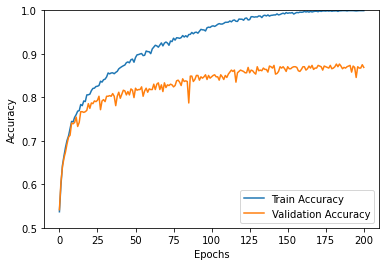

In [343]:
plt.plot(history.history['accuracy'][0:], label='Train Accuracy')
plt.plot(history.history['val_accuracy'][0:], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.legend()

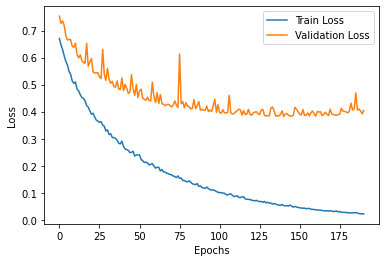

In [344]:
plt.plot(history.history['loss'][10:], label='Train Loss')
plt.plot(history.history['val_loss'][10:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [345]:
extra_fire_X_ex = np.load(os.path.join('data/dataset_test', 'extra_fire_X_ex.npy'))
extra_fire_X_ex_mel = np.load(os.path.join('data/dataset_test', 'extra_fire_X_ex_mel.npy'))
extra_fire_file = np.load(os.path.join('data/dataset_test', 'extra_fire_file.npy'))
extra_fire_y = np.load(os.path.join('data/dataset_test', 'extra_fire_y.npy'))

extra_fire_X_ex, extra_fire_X_ex_mel, extra_fire_y, extra_fire_file = shuffle(extra_fire_X_ex, extra_fire_X_ex_mel, extra_fire_y, extra_fire_file, random_state=1523)

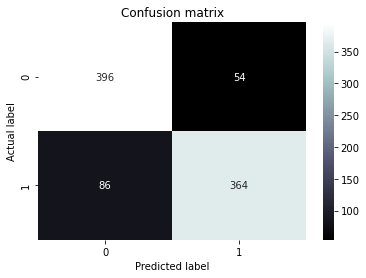

acc:  0.8444444444444444


In [346]:
Y_pred = model.predict(extra_fire_X_ex)
y_pred = np.argmax(Y_pred,axis=1)

tn, fp, fn, tp = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred).ravel()
matrix = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print('acc: ', (tn+tp)/(tn+fp+fn+tp))

In [347]:
tp / (tp+fn)

0.8088888888888889

In [348]:
tp / (tp+fp)

0.8708133971291866

In [349]:
best_model = models.load_model('model/train_X_ex_best.h5')

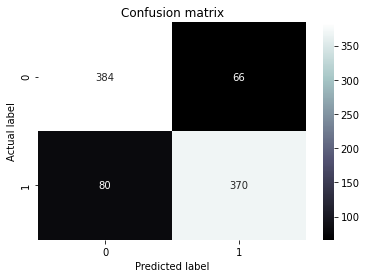

acc:  0.8377777777777777


In [350]:
Y_pred = best_model.predict(extra_fire_X_ex)
y_pred = np.argmax(Y_pred,axis=1)

tn, fp, fn, tp = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred).ravel()
matrix = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print('acc: ', (tn+tp)/(tn+fp+fn+tp))

In [145]:
y_pred

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [146]:
np.argmax(test_y,axis=1)

NameError: name 'test_y' is not defined

In [45]:
fn_result = []
fp_result = []
for n in range(0, len(test_y)):
    if y_pred[n] != np.argmax(test_y,axis=1)[n]:
        if(y_pred[n] == 1) :
            fp_result.append(n)
        else :
            fn_result.append(n)

NameError: name 'test_y' is not defined

In [46]:
print(len(fp_result))
print(len(fn_result))

47
16


In [47]:
for name in fp_result:
    print(test_file[name])

data/final/test_negative/0.17_bg_739_1.wav
data/final/test_negative/0.11_bg_969_30.wav
data/final/test_negative/0.88_bg_602_45.wav
data/final/test_negative/0.37_bg_1060_44.wav
data/final/test_negative/0.01_bg_861_44.wav
data/final/test_negative/0.46_bg_779_30.wav
data/final/test_negative/0.48_bg_881_15.wav
data/final/test_negative/0.57_bg_869_8.wav
data/final/test_negative/0.14_bg_650_32.wav
data/final/test_negative/0.29_bg_712_34.wav
data/final/test_negative/0.65_bg_769_22.wav
data/final/test_negative/0.06_bg_1005_13.wav
data/final/test_negative/0.03_bg_992_7.wav
data/final/test_negative/0.07_bg_849_35.wav
data/final/test_negative/0.13_bg_853_37.wav
data/final/test_negative/0.84_bg_785_34.wav
data/final/test_negative/0.68_bg_795_43.wav
data/final/test_negative/0.05_bg_715_36.wav
data/final/test_negative/0.33_bg_584_33.wav
data/final/test_negative/0.14_bg_728_42.wav
data/final/test_negative/0.14_bg_631_23.wav
data/final/test_negative/0.53_bg_770_23.wav
data/final/test_negative/0.53_bg_

In [48]:
import IPython.display

In [49]:
i = 0
wav = test_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/final/test_negative/0.17_bg_739_1.wav
1


In [ ]:
i = 1
wav = test_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [ ]:
i = 2
wav = test_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [50]:
for name in fn_result:
    print(test_file[name])

data/final/test/0.24_bg_524_m3.wav
data/final/test/0.24_bg_1_dh1.wav
data/final/test/0.19_bg_467_dh26.wav
data/final/test/0.49_bg_189_dh1.wav
data/final/test/0.3_bg_466_dh25.wav
data/final/test/0.19_bg_361_dh11.wav
data/final/test/0.39_bg_209_dh25.wav
data/final/test/0.19_bg_21_dh26.wav
data/final/test/0.52_bg_23_dj12.wav
data/final/test/0.41_bg_75_dh27.wav
data/final/test/0.43_bg_62_dh16.wav
data/final/test/0.13_bg_74_dh26.wav
data/final/test/0.23_bg_299_dh27.wav
data/final/test/0.26_bg_179_f2.wav
data/final/test/0.24_bg_53_dh1.wav
data/final/test/0.66_bg_108_dh18.wav


In [55]:
i = -1
wav = test_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/final/test/0.66_bg_108_dh18.wav
0


In [ ]:
i = 1
wav = test_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [ ]:
i = 2
wav = test_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [79]:
NON_DATA_DIR = 'data/final_test_clear/test_negative/'

extra_fire_X = []
extra_fire_spectrograms = []
extra_fire_mel_spectrograms = []
extra_fire_mfccs = []
extra_fire_y = []
extra_fire_file = []

for fname in os.listdir(NON_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        extra_fire_file.append(NON_DATA_DIR + fname)
        wav, sr = librosa.load(NON_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        mfcc_normalize = librosa.util.normalize(mfcc,norm=None)
        padded_mfcc = padding(mfcc_normalize, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        extra_fire_mfccs.append(padded_mfcc)
        extra_fire_mel_spectrograms.append(padded_mel_spectrogram)
        extra_fire_y.append(0)
    except Exception as e:
        print(fname, e)
        raise

In [80]:
extra_fire_DATA_DIR = 'data/final_test_clear/test/'

for fname in os.listdir(extra_fire_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        extra_fire_file.append(extra_fire_DATA_DIR + fname)
        wav, sr = librosa.load(extra_fire_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        mfcc_normalize = librosa.util.normalize(mfcc,norm=None)
        padded_mfcc = padding(mfcc_normalize, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        extra_fire_mfccs.append(padded_mfcc)
        extra_fire_mel_spectrograms.append(padded_mel_spectrogram)
        extra_fire_y.append(1)
    except Exception as e:
        print(fname, e)
        raise
        
extra_fire_mfccs = np.array(extra_fire_mfccs)
extra_fire_mel_spectrograms = np.array(extra_fire_mel_spectrograms)
extra_fire_y = np.array(extra_fire_y)
extra_fire_y = to_categorical(np.array(extra_fire_y))

extra_fire_X_ex = np.expand_dims(extra_fire_mfccs, -1)
extra_fire_X_ex_mel = np.expand_dims(extra_fire_mel_spectrograms, -1)

In [81]:
extra_fire_X_ex.shape

(900, 20, 63, 1)

In [82]:
np.save(os.path.join("data/dataset", "extra_fire_X_ex.npy"), extra_fire_X_ex)
np.save(os.path.join("data/dataset", "extra_fire_X_ex_mel.npy"), extra_fire_X_ex_mel)
np.save(os.path.join("data/dataset", "extra_fire_file.npy"), extra_fire_file)
np.save(os.path.join("data/dataset", "extra_fire_y.npy"), np.array(extra_fire_y))

In [83]:
extra_fire_X_ex = np.load(os.path.join('data/dataset_test', 'extra_fire_X_ex.npy'))
extra_fire_X_ex_mel = np.load(os.path.join('data/dataset_test', 'extra_fire_X_ex_mel.npy'))
extra_fire_file = np.load(os.path.join('data/dataset_test', 'extra_fire_file.npy'))
extra_fire_y = np.load(os.path.join('data/dataset_test', 'extra_fire_y.npy'))

extra_fire_X_ex, extra_fire_X_ex_mel, extra_fire_y, extra_fire_file = shuffle(extra_fire_X_ex, extra_fire_X_ex_mel, extra_fire_y, extra_fire_file, random_state=1523)

In [84]:
best_model = models.load_model('model/train_X_ex_best.h5')

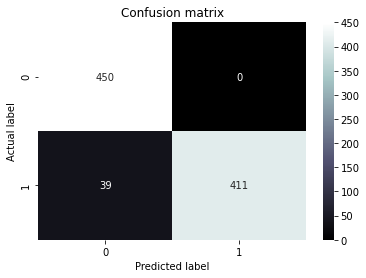

acc:  0.9566666666666667


In [85]:
#mfcc
Y_pred = model.predict(extra_fire_X_ex)
y_pred = np.argmax(Y_pred,axis=1)

tn, fp, fn, tp = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred).ravel()
matrix = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print('acc: ', (tn+tp)/(tn+fp+fn+tp))

In [76]:
y_pred

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,

In [86]:
fn_result = []
fp_result = []
for n in range(0, len(extra_fire_y)):
    if y_pred[n] != np.argmax(extra_fire_y,axis=1)[n]:
        if(y_pred[n] == 0) :
            fp_result.append(n)
        else :
            fn_result.append(n)

In [87]:
print(len(fp_result))
print(len(fn_result))

39
0


In [88]:
for name in fn_result:
    print(extra_fire_file[name])

In [95]:
import shutil

for file in fn_result:
    shutil.copy(extra_fire_file[file], 'data/false/'+extra_fire_file[file][30:])

In [94]:
extra_fire_file[name][30:]

'0.58_0.70375secs_bg_335_3.wav'

In [89]:
for name in fp_result:
    print(extra_fire_file[name])

data/final_test_clear/test/0.7210625secs_dh30.wav
data/final_test_clear/test/0.026375secs_m1.wav
data/final_test_clear/test/0.2893125secs_dh5.wav
data/final_test_clear/test/0.7815625secs_dh30.wav
data/final_test_clear/test/0.03925secs_dh30.wav
data/final_test_clear/test/0.695625secs_dh1.wav
data/final_test_clear/test/0.6336875secs_dh30.wav
data/final_test_clear/test/0.612875secs_dh29.wav
data/final_test_clear/test/0.6506875secs_dh30.wav
data/final_test_clear/test/0.6985625secs_dh2.wav
data/final_test_clear/test/0.013375secs_dh29.wav
data/final_test_clear/test/0.0391875secs_dh29.wav
data/final_test_clear/test/0.6590625secs_dh1.wav
data/final_test_clear/test/0.059secs_dh2.wav
data/final_test_clear/test/0.702625secs_dh2.wav
data/final_test_clear/test/0.739secs_dh1.wav
data/final_test_clear/test/0.184875secs_dh30.wav
data/final_test_clear/test/0.1115625secs_dh30.wav
data/final_test_clear/test/0.7536875secs_dh2.wav
data/final_test_clear/test/0.8440625secs_dh30.wav
data/final_test_clear/test

In [145]:
best_model = models.load_model('model/train_X_ex_mel_best.h5')

In [46]:
#mel spectrogram
Y_pred = best_model.predict(extra_fire_X_ex_mel)
y_pred = np.argmax(Y_pred,axis=1)

tn, fp, fn, tp = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred).ravel()
matrix = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print('acc: ', (tn+tp)/(tn+fp+fn+tp))

NameError: name 'best_model' is not defined

In [147]:
fn_result = []
fp_result = []
for n in range(0, len(extra_fire_y)):
    if y_pred[n] != np.argmax(extra_fire_y,axis=1)[n]:
        if(y_pred[n] == 0) :
            fp_result.append(n)
        else :
            fn_result.append(n)

In [148]:
print(len(fp_result))
print(len(fn_result))

41
2


In [97]:
for name in fp_result:
    print(extra_fire_file[name])

data/resampling/non/2.wav
data/resampling/non/3.wav
data/resampling/non/34.wav
data/resampling/non/43.wav
data/resampling/non/6.wav


In [96]:
i = 0
wav = extra_fire_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(extra_fire_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/resampling/fire/dh17.wav
0


In [98]:
for name in fn_result:
    print(extra_fire_file[name])

data/resampling/non/2.wav
data/resampling/non/3.wav
data/resampling/non/34.wav
data/resampling/non/43.wav
data/resampling/non/6.wav


In [100]:
i = 2
wav = extra_fire_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(extra_fire_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/resampling/non/34.wav
1


In [ ]:
y_pred

In [9]:
wav = 'non_tang.wav'
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)

wav shape:  (16030,)


In [13]:
#mfcc = librosa.feature.mfcc(y, sr=16000)
#padded_mfcc = pad2d(mfcc, 75)
mel_spectogram = librosa.feature.melspectrogram(y)
padded_mel_spectrogram = pad2d(mel_spectogram, 75)

In [14]:
test_mel_tang = np.array(padded_mel_spectrogram)
test_final = []
test_final.append(test_mel_tang)
test_final = np.expand_dims(test_final, -1)

In [15]:
test_final

(1, 128, 75, 1)

In [16]:
test_X_ex_mel.shape

(300, 128, 50, 1)

In [ ]:
Y_pred = model.predict(test_final)
y_pred = np.argmax(Y_pred,axis=1)

In [ ]:
y_pred